In [ ]:
import pandas as pd

In [ ]:
customers=pd.read_csv("/content/Customers.csv")
transactions=pd.read_csv("/content/Transactions.csv")

In [ ]:
#first 5 rows
print("The first five rows of customers:")
print(customers.head())
print("The first five rows of transactions:")
print(transactions.head())


The first five rows of customers:
  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
The first five rows of transactions:
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue   Price  
0      300.68  300.68  
1      300.68  300.68  
2      300.68  300.68  
3      601.36  300.68  
4      902.04  300.68 

In [ ]:
#last 5 rows
print("The first five rows of customers:")
print(customers.tail())
print("The first five rows of transactions:")
print(transactions.tail())

The first five rows of customers:
    CustomerID      CustomerName  Region  SignupDate
195      C0196       Laura Watts  Europe  2022-06-07
196      C0197  Christina Harvey  Europe  2023-03-21
197      C0198       Rebecca Ray  Europe  2022-02-27
198      C0199    Andrea Jenkins  Europe  2022-12-03
199      C0200       Kelly Cross    Asia  2023-06-11
The first five rows of transactions:
    TransactionID CustomerID ProductID      TransactionDate  Quantity  \
995        T00496      C0118      P037  2024-10-24 08:30:27         1   
996        T00759      C0059      P037  2024-06-04 02:15:24         3   
997        T00922      C0018      P037  2024-04-05 13:05:32         4   
998        T00959      C0115      P037  2024-09-29 10:16:02         2   
999        T00992      C0024      P037  2024-04-21 10:52:24         1   

     TotalValue   Price  
995      459.86  459.86  
996     1379.58  459.86  
997     1839.44  459.86  
998      919.72  459.86  
999      459.86  459.86  


In [ ]:
# Data Preprocessing
# Convert dates to datetime format
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

In [ ]:
# Extract additional features from SignupDate
customers['SignupYear'] = customers['SignupDate'].dt.year
customers['SignupMonth'] = customers['SignupDate'].dt.month

In [ ]:
# Aggregate transaction data per customer
transaction_features = transactions.groupby('CustomerID').agg(
    TotalSpending=('TotalValue', 'sum'),
    NumTransactions=('TransactionID', 'count'),
    AvgSpending=('TotalValue', 'mean'),
    AvgQuantity=('Quantity', 'mean')
).reset_index()


In [ ]:
# Combine profile and transaction data
profile_features = customers[['CustomerID', 'Region', 'SignupYear', 'SignupMonth']]
data_combined = pd.merge(profile_features, transaction_features, on="CustomerID", how="left")

In [ ]:
# One-hot encoding for categorical features (Region)
data_combined = pd.get_dummies(data_combined, columns=['Region'], drop_first=True)

In [ ]:
# Fill missing values in transaction data
for col in ['TotalSpending', 'NumTransactions', 'AvgSpending', 'AvgQuantity']:
    data_combined[col] = data_combined[col].fillna(0)



In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Feature Scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data_combined.drop('CustomerID', axis=1))

In [ ]:
# K-Means Clustering
n_clusters = 5  # You can adjust this value based on the DB Index
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
data_combined['Cluster'] = kmeans.fit_predict(scaled_features)

In [ ]:
# Clustering Evaluation
db_index = davies_bouldin_score(scaled_features, data_combined['Cluster'])
silhouette = silhouette_score(scaled_features, data_combined['Cluster'])


In [ ]:
# Print Evaluation Metrics
print(f"DB Index: {db_index}")
print(f"Silhouette Score: {silhouette}")

DB Index: 1.8079486957486886
Silhouette Score: 0.17252689538267274


In [ ]:
# Visualizing the Clusters using PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)
data_combined['PCA1'] = pca_result[:, 0]
data_combined['PCA2'] = pca_result[:, 1]


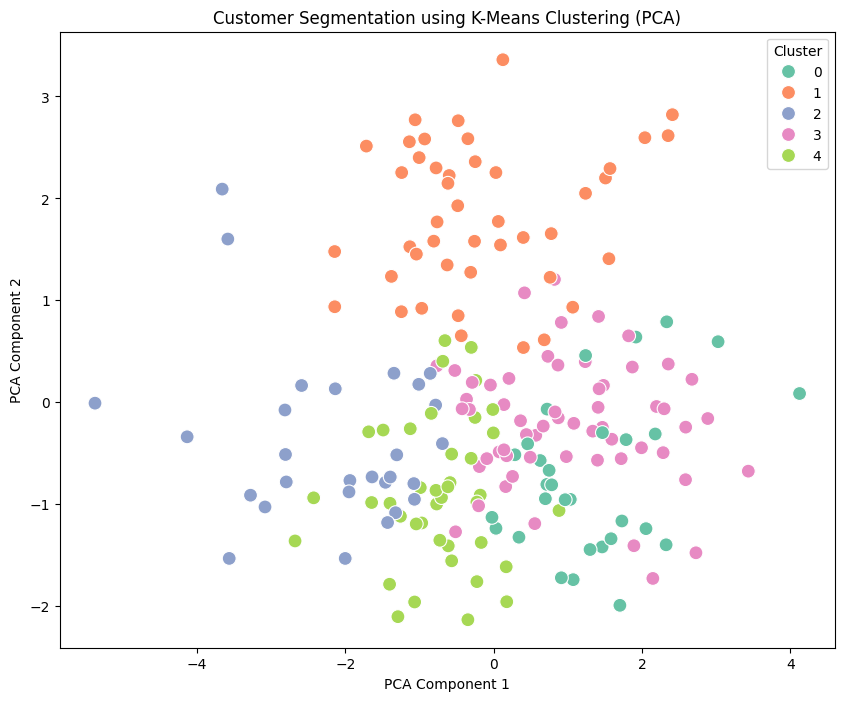

In [ ]:
# Plot the clusters using PCA
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PCA1', y='PCA2', hue='Cluster', palette='Set2', data=data_combined, s=100
)
plt.title('Customer Segmentation using K-Means Clustering (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()


In [ ]:
import numpy as np

In [ ]:
# Ensure only numeric columns are included in the groupby operation
numeric_columns = data_combined.select_dtypes(include=[np.number]).columns.drop("Cluster")

# Group by 'Cluster' and calculate the mean for numeric columns only
cluster_summary = data_combined.groupby('Cluster')[numeric_columns].mean().reset_index()

print(cluster_summary)


   Cluster   SignupYear  SignupMonth  TotalSpending  NumTransactions  \
0        0  2023.400000     7.466667    4942.975000         5.533333   
1        1  2023.363636     5.954545    3449.645909         5.500000   
2        2  2023.107143     7.214286    1109.070357         2.500000   
3        3  2022.913793     5.724138    4498.272931         6.155172   
4        4  2022.725000     5.625000    2449.202250         4.125000   

   AvgSpending  AvgQuantity      PCA1      PCA2  
0   934.468886     2.974061  1.320467 -0.740980  
1   657.023298     2.510899 -0.165025  1.826819  
2   416.964720     1.900000 -2.180371 -0.386539  
3   745.918812     2.622017  1.004572 -0.200678  
4   623.676531     2.466250 -0.739193 -0.892206  


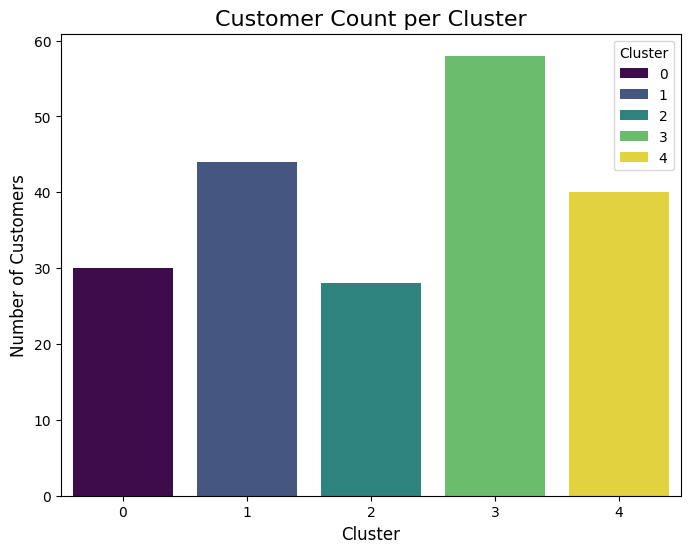

In [ ]:
# Count of customers in each cluster
cluster_counts = data_combined['Cluster'].value_counts().sort_index()

plt.figure(figsize=(8, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, hue=cluster_counts.index, palette="viridis", dodge=False)
plt.title("Customer Count per Cluster", fontsize=16)
plt.xlabel("Cluster", fontsize=12)
plt.ylabel("Number of Customers", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Cluster", fontsize=10, loc="upper right")
plt.show()


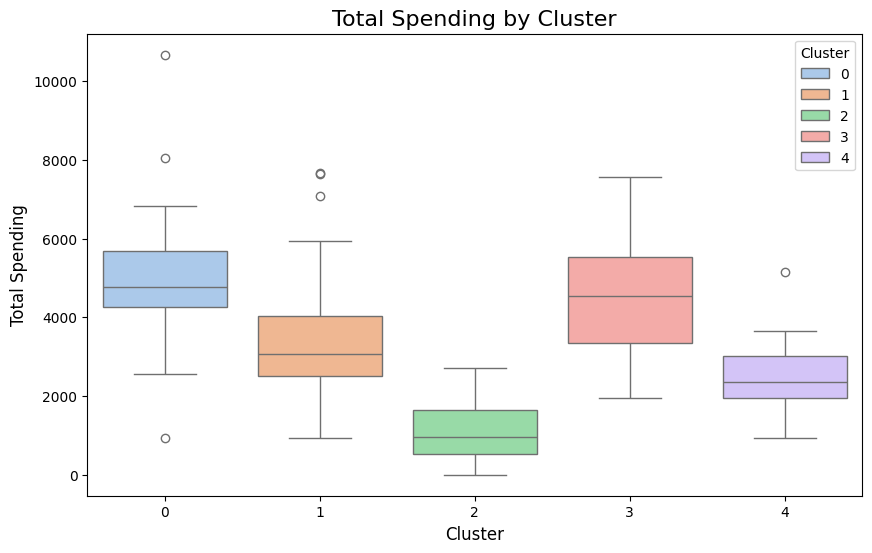

In [ ]:
#Boxplot of Spending Across Clusters
plt.figure(figsize=(10, 6))
sns.boxplot(x="Cluster", y="TotalSpending", data=data_combined, hue="Cluster", palette="pastel")
plt.title("Total Spending by Cluster", fontsize=16)
plt.xlabel("Cluster", fontsize=12)
plt.ylabel("Total Spending", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Cluster", fontsize=10, loc="upper right")
plt.show()



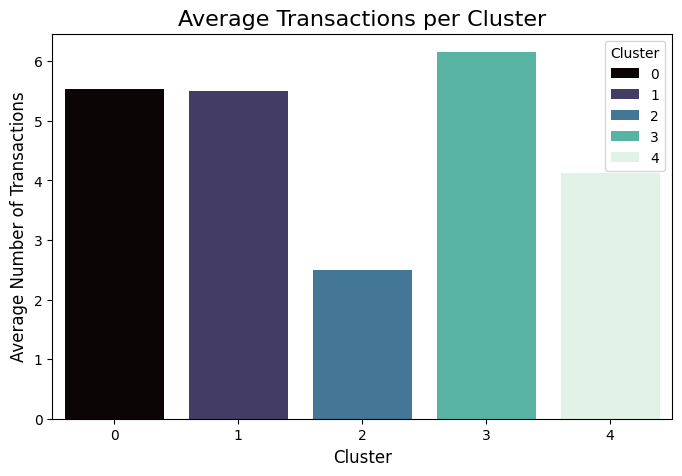

In [ ]:
# Visualization: Average Transactions per Cluster
plt.figure(figsize=(8, 5))
sns.barplot(x=avg_transactions.index, y=avg_transactions.values, palette="mako", hue=avg_transactions.index, dodge=False)
plt.title("Average Transactions per Cluster", fontsize=16)
plt.xlabel("Cluster", fontsize=12)
plt.ylabel("Average Number of Transactions", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Cluster", fontsize=10, loc="upper right")
plt.show()

